
# ANTs × Cellpose Registration QC — Centroid Distances in µm

**Created:** 2025-10-15 12:22

This notebook computes distances (in µm) between **cort-positive cell centroids** segmented by Cellpose in two modalities:
- **Confocal** (panneuronal GC + cort HCR in red) — *moving image* (registered to 2P)
- **2P** (panneuronal GC + cort::mCherry) — *fixed image*

The pipeline:
1. Load Cellpose `*_seg.npy` outputs and extract labeled masks.
2. Compute object centroids.
3. Convert pixel indices to physical units using voxel spacings (µm).
4. Apply the **confocal → 2P** ANTs transform to confocal centroids.
5. Match cells (nearest neighbor or Hungarian) and compute distances in µm.
6. Summaries and basic plots; optional gating to reject outliers.



## Requirements

- `numpy`, `pandas`, `scikit-image`, `scipy`, `matplotlib`
- `ants` (ANTsPy) **optional but recommended** for applying transforms inside Python.
  - If `ants` is not available, the notebook will export centroids to CSV and you can run
    `antsApplyTransformsToPoints` on the command line, then re-import the transformed CSV.

> Tip: For 3D Cellpose, pass correct anisotropy during segmentation to reduce z-bias.


## 0) User inputs

In [1]:

# --- Paths to Cellpose outputs ---
CONF_SEG_NPY = "/Users/ddharmap/dataProcessing/2p_HCR/data/L427_f02/L427_f02_round1_channel2_cort_gauss_seg_20251006.npy"   # path to confocal *_seg.npy
TWOP_SEG_NPY = "/Users/ddharmap/dataProcessing/2p_HCR/data/L427_f02/L427_f02_anatomy_2P_cort_seg_anis1.npy"       # path to 2P *_seg.npy

# --- ANTs transform files (moving=confocal -> fixed=2P) ---
# include the non-linear warp BEFORE the affine in the list
ANTs_TRANSFORMS = [
    "/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/01_r1-2p/transMatrices/L427_f02_round1_GCaMP_to_ref1Warp.nii.gz",          # example SyN warp
    "/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L427_f02/02_reg/01_r1-2p/transMatrices/L427_f02_round1_GCaMP_to_ref0GenericAffine.mat"     # example affine
]

# --- Voxel spacings in microns ---
# Fill these from your image metadata
# 3D stacks: dz, dy, dx; 2D stacks: dy, dx
VOX_CONF = {"dz": 1.0, "dy": 0.2075665, "dx": 0.2075665}  # example for confocal
VOX_2P   = {"dz": 2.0, "dy": 0.6506220, "dx": 0.6506220}  # example for 2P

# --- Matching parameters ---
MATCH_METHOD = "nn"    # "nn" for nearest neighbor, "hungarian" for 1–1 global assignment
MAX_DISTANCE_UM = 5.0 # gate for valid matches (~1 soma diameter is a good start)
RANDOM_SEED = 42


## 1) Imports and helper functions

In [10]:

import os, sys, json, time
import numpy as np
import pandas as pd

from skimage.measure import regionprops_table
from scipy.spatial import cKDTree
from scipy.optimize import linear_sum_assignment

import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Dropdown

# Try to import ANTsPy
try:
    import ants
    HAVE_ANTSPY = True
except Exception as e:
    HAVE_ANTSPY = False
    print("ANTsPy not found; will enable CSV export/import route for transforms.\n", e)

rng = np.random.default_rng(RANDOM_SEED)

def fs_info(path: str) -> dict:
    """Lightweight filesystem info."""
    exists = os.path.exists(path)
    size_b = os.path.getsize(path) if exists else None
    mtime  = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(os.path.getmtime(path))) if exists else None
    return {"exists": exists, "size_bytes": size_b, "size_MB": (size_b/1e6 if size_b else None), "modified": mtime}

def physical_extent_um(mask: np.ndarray, vox: dict) -> tuple:
    """Return (Z_um, Y_um, X_um) or (Y_um, X_um) physical field-of-view from mask shape and voxel sizes."""
    if mask.ndim == 3:
        Z, Y, X = mask.shape
        return (Z * vox["dz"], Y * vox["dy"], X * vox["dx"])
    else:
        Y, X = mask.shape
        return (Y * vox["dy"], X * vox["dx"])

def summarize_dataset(name: str, path: str, masks: np.ndarray, vox: dict) -> dict:
    """One-row summary for a dataset (used in the table view)."""
    base = os.path.basename(path)
    fs = fs_info(path)
    uniq = np.unique(masks)
    n_cells = int(uniq.size - (1 if uniq.size and uniq[0] == 0 else 0))
    fov = physical_extent_um(masks, vox)
    row = {
        "dataset": name,
        "file": base,
        "path": path,
        "exists": fs["exists"],
        "size_MB": round(fs["size_MB"], 3) if fs["size_MB"] else None,
        "modified": fs["modified"],
        "shape": tuple(masks.shape),
        "ndim": masks.ndim,
        "dtype": str(masks.dtype),
        "min_label": int(masks.min()),
        "max_label": int(masks.max()),
        "n_cells": n_cells,
        "voxel_um": (vox["dz"], vox["dy"], vox["dx"]) if masks.ndim == 3 else (vox["dy"], vox["dx"]),
        "FOV_um": tuple(round(v, 3) for v in fov),
        "n_voxels": int(masks.size),
        "anisotropy_z_over_y": (vox["dz"]/vox["dy"]) if masks.ndim == 3 else None,
    }
    return row

def load_cellpose_masks(seg_path: str) -> np.ndarray:
    """Robustly load Cellpose *_seg.npy (dict) or a raw label array (.npy/.npz).
    Returns a labeled mask ndarray (2D or 3D).
    """
    if not os.path.exists(seg_path):
        raise FileNotFoundError(f"File not found: {seg_path}")

    try:
        obj = np.load(seg_path, allow_pickle=True)
    except Exception as e:
        raise OSError(f"Failed to load {seg_path}. If this is on a network/cloud drive, "
                      f"copy it locally and retry. Original error: {e}")

    # .npz container?
    if isinstance(obj, np.lib.npyio.NpzFile):
        if 'masks' in obj.files:
            return obj['masks']
        raise KeyError(f"{seg_path} is .npz but has no 'masks'. Keys: {obj.files}")

    # Cellpose *_seg.npy is a pickled dict inside an .npy
    if hasattr(obj, "item"):
        try:
            dat = obj.item()
        except Exception as e:
            raise OSError(f"{seg_path} appears corrupted (cannot unpickle dict). {e}")
        masks = dat.get('masks', None)
        if masks is None:
            raise KeyError(f"'masks' not found in {seg_path}. Keys: {list(dat.keys())}")
        return masks

    # raw array case
    if isinstance(obj, np.ndarray):
        return obj

    raise TypeError(f"Unexpected content in {seg_path}: {type(obj)}")

def mask_summary(mask: np.ndarray, name: str = "") -> dict:
    """Return a small dict summarizing a labeled mask."""
    # unique() can be heavy for huge volumes; use it here for truth, but you can swap to mask.max() if needed
    uniq = np.unique(mask)
    n_cells = int(uniq.size - (1 if uniq.size and uniq[0] == 0 else 0))
    return {
        "name": name,
        "shape": tuple(mask.shape),
        "ndim": mask.ndim,
        "dtype": str(mask.dtype),
        "min": int(mask.min()),
        "max": int(mask.max()),
        "n_cells": n_cells,
    }

def safe_slice(arr: np.ndarray, z: int) -> np.ndarray:
    """Return arr[z] for 3D, or arr for 2D, with z safely clamped."""
    if arr.ndim == 2:
        return arr
    z = int(np.clip(z, 0, arr.shape[0] - 1))
    return arr[z]


def compute_centroids(mask):
    """Return DataFrame of labels and centroids from a labeled mask (2D or 3D)."""
    props = regionprops_table(mask, properties=("label", "centroid"))
    df = pd.DataFrame(props)
    # Ensure consistent column names: z,y,x for 3D; y,x for 2D
    if mask.ndim == 3:
        df = df.rename(columns={"centroid-0":"z", "centroid-1":"y", "centroid-2":"x"})
    else:
        df = df.rename(columns={"centroid-0":"y", "centroid-1":"x"})
    return df

def idx_to_um(df_centroids, vox):
    """Convert centroid indices to microns using spacing dict vox."""
    if "z" in df_centroids.columns:
        arr = df_centroids[["z","y","x"]].to_numpy(dtype=float)
        arr[:,0] *= vox["dz"]
        arr[:,1] *= vox["dy"]
        arr[:,2] *= vox["dx"]
        return arr
    else:
        arr = df_centroids[["y","x"]].to_numpy(dtype=float)
        arr[:,0] *= vox["dy"]
        arr[:,1] *= vox["dx"]
        return arr

def um_to_idx_df(points_um, vox, is3d):
    """Convert points in µm to MOVING image index units with columns x,y,(z)."""
    if is3d:
        return pd.DataFrame({
            "x": points_um[:,2] / vox["dx"],
            "y": points_um[:,1] / vox["dy"],
            "z": points_um[:,0] / vox["dz"],
        })[["x","y","z"]]
    else:
        return pd.DataFrame({
            "x": points_um[:,1] / vox["dx"],
            "y": points_um[:,0] / vox["dy"],
        })[["x","y"]]

def idx_df_to_um(df_idx, vox, is3d):
    """Convert FIXED image index-units DataFrame (x,y,(z)) to µm ndarray (ordered as y/x -> µm & z first for 3D)."""
    if is3d:
        x = df_idx["x"].to_numpy(); y = df_idx["y"].to_numpy(); z = df_idx["z"].to_numpy()
        return np.c_[ z * vox["dz"],  y * vox["dy"],  x * vox["dx"] ]  # returns [µm_z, µm_y, µm_x]
    else:
        x = df_idx["x"].to_numpy(); y = df_idx["y"].to_numpy()
        return np.c_[ y * vox["dy"],  x * vox["dx"] ]  # returns [µm_y, µm_x]

def apply_ants_transform_to_points(conf_pts_um, is3d, ants_transforms, vox_conf, vox_2p):
    """Apply confocal->2P transforms to confocal points in µm. Return points in 2P µm."""
    if not HAVE_ANTSPY:
        raise RuntimeError("ANTsPy not available.")
    moving_idx = um_to_idx_df(conf_pts_um, vox_conf, is3d)
    # antspyx signature: apply_transforms_to_points(dim, points, transformlist, whichtoinvert=None)
    fixed_idx = ants.apply_transforms_to_points(3 if is3d else 2, moving_idx, ants_transforms)
    fixed_um = idx_df_to_um(fixed_idx, vox_2p, is3d)
    return fixed_um

def nearest_neighbor_match(A_um, B_um):
    """For each row in A, find nearest neighbor in B. Returns distances and indices."""
    tree = cKDTree(B_um)
    dists, nn = tree.query(A_um, k=1)
    return dists, nn

def hungarian_match(A_um, B_um, max_cost=np.inf):
    """1–1 assignment using Hungarian algorithm with optional max_cost gate."""
    # Compute cost matrix
    # Beware of large N: O(N^2) memory
    from scipy.spatial.distance import cdist
    C = cdist(A_um, B_um)
    if np.isfinite(max_cost):
        C = np.where(C > max_cost, max_cost * 10.0, C)  # penalize invalid matches
    row_ind, col_ind = linear_sum_assignment(C)
    dists = C[row_ind, col_ind]
    return dists, col_ind, row_ind

def summarize_distances(dists, valid_mask):
    if valid_mask.any():
        return {
            "N_total": int(dists.size),
            "N_within_gate": int(valid_mask.sum()),
            "frac_within_gate": float(valid_mask.mean()),
            "median_um": float(np.median(dists[valid_mask])),
            "p90_um": float(np.percentile(dists[valid_mask], 90)),
        }
    else:
        return {
            "N_total": int(dists.size),
            "N_within_gate": 0,
            "frac_within_gate": 0.0,
            "median_um": np.nan,
            "p90_um": np.nan,
        }


## 3) Inspect datasets

In [12]:
# ==== Table-format oversight of input datasets ====
# assumes:
#   - masks_conf, masks_2p already loaded
#   - CONF_SEG_NPY, TWOP_SEG_NPY, VOX_CONF, VOX_2P already defined


masks_conf = load_cellpose_masks(CONF_SEG_NPY)
masks_2p   = load_cellpose_masks(TWOP_SEG_NPY)

rows = [
    summarize_dataset("Confocal (HCR)", CONF_SEG_NPY, masks_conf, VOX_CONF),
    summarize_dataset("2P (mCherry)",   TWOP_SEG_NPY, masks_2p,   VOX_2P),
]

df_inputs = pd.DataFrame(rows)

# choose a readable column order
cols = [
    "dataset","file","exists","size_MB","modified",
    "shape","ndim","dtype","min_label","max_label","n_cells",
    "voxel_um","FOV_um","n_voxels","anisotropy_z_over_y","path"
]
df_inputs = df_inputs[cols]

# display + (optional) save
display(df_inputs.style.format({"size_MB": "{:.3f}"}))
df_inputs.to_csv("input_datasets_overview.csv", index=False)
print("Saved table to input_datasets_overview.csv")


AttributeError: The '.style' accessor requires jinja2

## 4) Load Cellpose masks and compute centroids

In [ ]:
is3d = (masks_conf.ndim == 3)
assert masks_2p.ndim == masks_conf.ndim, "Confocal and 2P masks must have same dimensionality (both 2D or both 3D)."

df_conf = compute_centroids(masks_conf)
df_2p   = compute_centroids(masks_2p)

print("Confocal centroids:", df_conf.shape, "| 2P centroids:", df_2p.shape)
df_conf.head(), df_2p.head()

# Print concise summaries
for m, n in [(masks_conf, "Confocal (HCR)"), (masks_2p, "2P (mCherry)")]:
    s = mask_summary(m, n)
    print(f"[{s['name']}] shape={s['shape']} ndim={s['ndim']} dtype={s['dtype']} "
          f"min={s['min']} max={s['max']} cells={s['n_cells']}")

# Interactive viewer
def _browse(which: str = "Confocal", z: int = 0):
    arr = masks_conf if which == "Confocal" else masks_2p
    img = safe_slice(arr, z)
    plt.figure()
    plt.imshow(img, cmap="nipy_spectral", interpolation="nearest")
    if arr.ndim == 3:
        plt.title(f"{which} — z={int(np.clip(z, 0, arr.shape[0]-1))}/{arr.shape[0]-1}")
    else:
        plt.title(f"{which} — 2D mask")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Set slider range to cover the larger Z; safe_slice() clamps for the smaller stack.
zmax = max(masks_conf.shape[0] if masks_conf.ndim == 3 else 1,
           masks_2p.shape[0]   if masks_2p.ndim   == 3 else 1) - 1
interact(
    _browse,
    which=Dropdown(options=["Confocal", "2P"], value="Confocal", description="Stack"),
    z=IntSlider(min=0, max=max(0, zmax), step=1, value=0, description="z-plane")
);


Confocal centroids: (191, 4) | 2P centroids: (939, 4)
[Confocal (HCR)] shape=(155, 2048, 2048) ndim=3 dtype=uint16 min=0 max=191 cells=191
[2P (mCherry)] shape=(196, 750, 750) ndim=3 dtype=uint16 min=0 max=939 cells=939


interactive(children=(Dropdown(description='Stack', options=('Confocal', '2P'), value='Confocal'), IntSlider(v…

## 3) Convert centroids to physical units (µm)

In [10]:

P_conf_um = idx_to_um(df_conf, VOX_CONF)
P_2p_um   = idx_to_um(df_2p,   VOX_2P)
print(f"P_conf_um shape: {P_conf_um.shape}, P_2p_um shape: {P_2p_um.shape}")


P_conf_um shape: (191, 3), P_2p_um shape: (939, 3)


## 4) Apply ANTs transform (confocal → 2P)

In [13]:

if HAVE_ANTSPY:
    print("Applying ANTs transform via ANTsPy...")
    P_conf_in_2p_um = apply_ants_transform_to_points(P_conf_um, is3d, ANTs_TRANSFORMS, VOX_CONF, VOX_2P)
else:
    print("ANTsPy not available. Exporting confocal centroids to CSV for antsApplyTransformsToPoints...")
    export_csv = "conf_centroids_input_points.csv"
    # antsApplyTransformsToPoints expects columns: x,y,(z) in index units of the MOVING image.
    moving_idx = um_to_idx_df(P_conf_um, VOX_CONF, is3d)
    moving_idx.to_csv(export_csv, index=False)
    print(f"Wrote {export_csv}.")
    print("""
Next steps (outside Python):
  antsApplyTransformsToPoints -d {2 if not is3d else 3}     -i conf_centroids_input_points.csv     -o conf_centroids_in_2p_index.csv     -t { ' -t '.join(ANTs_TRANSFORMS) }     --precision float
Then re-import here:
    fixed_idx = pd.read_csv("conf_centroids_in_2p_index.csv")
    P_conf_in_2p_um = idx_df_to_um(fixed_idx, VOX_2P, is3d)
""".strip())
    P_conf_in_2p_um = None


Applying ANTs transform via ANTsPy...


## 5) Match cells and compute distances

In [14]:

if P_conf_in_2p_um is None:
    raise RuntimeError("Transformed confocal centroids not available yet. Complete the ANTs step then re-run.")

labels_conf = df_conf["label"].to_numpy()
labels_2p   = df_2p["label"].to_numpy()

if MATCH_METHOD == "nn":
    dists, nn = nearest_neighbor_match(P_conf_in_2p_um, P_2p_um)
    matched_twoP_labels = labels_2p[nn]
    matched_conf_labels = labels_conf
elif MATCH_METHOD == "hungarian":
    dists, col_ind, row_ind = hungarian_match(P_conf_in_2p_um, P_2p_um, max_cost=np.inf)
    # reorder labels to align with row_ind
    matched_conf_labels = labels_conf[row_ind]
    matched_twoP_labels = labels_2p[col_ind]
else:
    raise ValueError("MATCH_METHOD must be 'nn' or 'hungarian'")

valid = dists <= MAX_DISTANCE_UM

matches = pd.DataFrame({
    "conf_label": matched_conf_labels,
    "twoP_label": matched_twoP_labels,
    "distance_um": dists,
    "within_gate": valid
})
print(matches.head())

summary = summarize_distances(dists, valid)
print("Summary:", json.dumps(summary, indent=2))


   conf_label  twoP_label  distance_um  within_gate
0           1          85   556.063718        False
1           2          85   601.182458        False
2           3          57   606.645041        False
3           4          57   595.958111        False
4           5          57   631.167258        False
Summary: {
  "N_total": 191,
  "N_within_gate": 0,
  "frac_within_gate": 0.0,
  "median_um": NaN,
  "p90_um": NaN
}


## 6) Plots

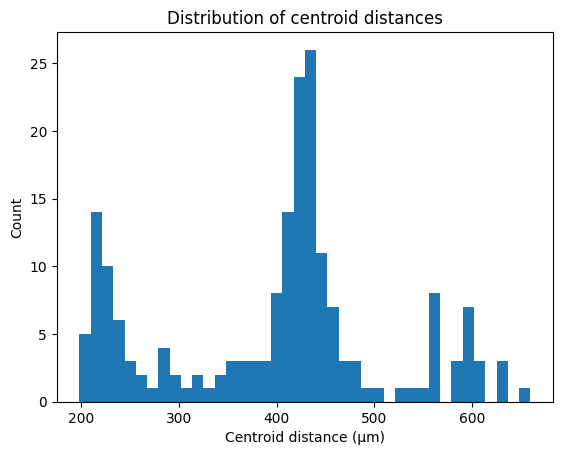

In [15]:

# Distance histogram
plt.figure()
plt.hist(matches["distance_um"].to_numpy(), bins=40)
plt.xlabel("Centroid distance (µm)")
plt.ylabel("Count")
plt.title("Distribution of centroid distances")
plt.show()


In [ ]:
try:
    from ipywidgets import interact, FloatSlider, FloatLogSlider, Checkbox
except Exception as e:
    print("ipywidgets not available:", e)
    raise

# convenience projections
Z2, Y2, X2 = P_2p_um[:,0], P_2p_um[:,1], P_2p_um[:,2]
Zc, Yc, Xc = P_conf_in_2p_um[:,0], P_conf_in_2p_um[:,1], P_conf_in_2p_um[:,2]

zmin = float(min(Z2.min(), Zc.min()))
zmax = float(max(Z2.max(), Zc.max()))
default_thick = 4.0  # µm half-thickness on each side of the slider plane

def _plot_slice(z_um=0.0, thickness_um=default_thick, show_conf=True, show_2p=True, show_matches=False):
    plt.figure()
    # 2P points in the slab
    if show_2p:
        m2 = np.abs(Z2 - z_um) <= thickness_um
        plt.scatter(X2[m2], Y2[m2], s=8, label="2P", alpha=0.9)
    # confocal→2P points in the slab
    if show_conf:
        mc = np.abs(Zc - z_um) <= thickness_um
        plt.scatter(Xc[mc], Yc[mc], s=8, alpha=0.6, label="Conf→2P")
    # optional: draw match lines for pairs whose both endpoints fall in the slab
    if show_matches and 'matches' in globals():
        # build quick label→coord maps
        coord_2p = dict(zip(df_2p["label"].to_numpy(), P_2p_um))
        coord_conf = dict(zip(df_conf["label"].to_numpy(), P_conf_in_2p_um))
        for _, row in matches.iterrows():
            a = coord_conf.get(int(row["conf_label"]))
            b = coord_2p.get(int(row["twoP_label"]))
            if a is None or b is None:
                continue
            if (abs(a[0]-z_um) <= thickness_um) and (abs(b[0]-z_um) <= thickness_um):
                plt.plot([a[2], b[2]], [a[1], b[1]], linewidth=0.5)

    plt.gca().invert_yaxis()
    plt.xlabel("x (µm)")
    plt.ylabel("y (µm)")
    plt.title(f"Centroids near z = {z_um:.2f} µm (±{thickness_um:.2f})")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

interact(
    _plot_slice,
    z_um=FloatSlider(min=zmin, max=zmax, step=0.5, value=(zmin+zmax)/2, description="z (µm)"),
    thickness_um=FloatSlider(min=0.5, max=20.0, step=0.5, value=default_thick, description="slab ±µm"),
    show_conf=Checkbox(value=True, description="show Conf→2P"),
    show_2p=Checkbox(value=True, description="show 2P"),
    show_matches=Checkbox(value=False, description="show match lines"),
);

## 7) Save results

In [ ]:

out_matches_csv = "centroid_matches.csv"
matches.to_csv(out_matches_csv, index=False)
print(f"Wrote {out_matches_csv}")

out_summary_json = "qc_summary.json"
with open(out_summary_json, "w") as f:
    json.dump(summary, f, indent=2)
print(f"Wrote {out_summary_json}")



## Notes & Tips

- **Transform direction**: These steps assume your ANTs transform maps *confocal → 2P*. If your files represent the reverse direction, invert them or swap roles.
- **Gate selection**: Start with ~1 soma diameter (e.g., 8–12 µm for juvenile zebrafish thalamus). Report fraction within gate, median, p90.
- **Outliers**: Investigate > gate by cropping around predicted pairs; often due to segmentation misses or local warp strain.
- **Warp health**: Consider computing a log-Jacobian image from the SyN warp and correlating distance outliers with high-deformation regions.
- **Reproducibility**: Keep a copy of your exact `VOX_*`, transform filenames, and Cellpose versions alongside the outputs.
